# Spike Sorting

HD-MEAの各電極で観測される信号には，複数の細胞からの信号が混在している．また，{doc}`01_spike_detection`でみたように，単一の神経細胞の信号が複数の電極にまたがって観測される．単一の神経細胞の発火時刻に関する情報を得るには，複数細胞の活動電位が混在した信号を，統計処理により個々の細胞の信号に分離する操作が必要である．これをspike sortingと呼ぶ．

以下の画像は，HD-MEA上に培養された神経細胞を，神経突起のマーカーであるMAP2により免疫染色し，電気活動と重ね合わせた図である．{cite}`muller2015high`より引用した．

<img src="https://pubs.rsc.org/image/article/2015/lc/c5lc00133a/c5lc00133a-f4_hi-res.gif" width=600 title="Electrical activity superimposed to a MAP2 staining of the neurons.">

図上には神経細胞が3つ存在する．電極3を例にとると，3つの神経細胞の信号が混在しているものの，各神経細胞の空間的な分布が異なるために，spike波形の形状や振幅が異なることがわかる．**神経細胞により各電極で観測されるspike波形の形状が異なる**という前提に立ち，spike波形を統計的にクラスタリングすることにより，各細胞（**unit**と呼ばれる）の信号を推定することが可能である．

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, find_peaks
from scipy import stats

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 200

In [2]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(sig, lowcut, highcut, fs, order=3):    
    if sig.ndim == 1:
        sig = np.atleast_2d(sig)
        
    sig = (sig - np.mean(sig, axis=1).reshape(-1, 1))  # offset with average
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, sig)  # zero-phase filter

def peak_detection(sig, thr, distance=50):
    peaks, _ = find_peaks(-1 * sig, height=thr, distance=distance)
    return peaks

def thr_mad(sig, n=7):
    return stats.median_abs_deviation(sig) * n

In [3]:
datadir = '../datasets/04/'
fs = 20000

# read signal
with h5py.File(datadir + 'data.raw.h5', 'r') as f:
    sig = f['sig'][()]
    mapping = f['mapping'][()]
    
# read electrode mapping
df_map = pd.DataFrame(mapping)

n_channels, n_frames = sig.shape

# filter signal
sig = bandpass_filter(sig, lowcut=300, highcut=5000, fs=fs)
amps = np.max(sig, axis=1) - np.min(sig, axis=1)  # amplitude range for each channel

## Waveform Extraction

まず，単一の電極についてピーク検出し，spikeの波形を抽出する．ピーク時刻（spike時刻）を$t_s$ [ms]とし，次の区間で信号の波形を取り出す．

$$
[t_s - t_{pre}, \ t_s + t_{post}]
$$

本ノートブックでは，$t_{pre}=1, t_{post}=2$ [ms]とする．
サンプリング周波数$f_s=20 \mathrm{kHz}$とすると，抽出される信号の次元は$(t_{pre} + t_{post}) \cdot f_s$である．

In [4]:
def extract_waveforms(sig, peaks, n_pre=20, n_post=40):
    sig = np.atleast_2d(sig)
    n_channels, n_frames = sig.shape

    peaks = np.sort(peaks)
    peaks_ = peaks[(n_pre <= peaks) & (peaks <= n_frames - n_post)]  # waveforms must be within data range
    waveforms = np.array([sig[:, peak - n_pre: peak + n_post] for peak in peaks_])
    return peaks_, waveforms


def concat_waveforms(waveforms):
    waveforms = np.atleast_3d(waveforms)
    n_peaks, n_channels, n_frames = waveforms.shape
    return waveforms.reshape(-1, n_channels * n_frames)

最大振幅をもつ電極でspike検出し，spike周辺の波形を抽出する．

In [5]:
# spike detection at the channel with maximum amplitude range
s = sig[np.argmax(amps)]
peaks = peak_detection(sig=s, thr=thr_mad(s), distance=50)

In [6]:
t_pre, t_post = 1, 2  # ms
n_pre, n_post = int(t_pre * fs / 1000), int(t_post * fs / 1000)
t = np.arange(-t_pre, t_post, 1000 / fs)

peaks, waveforms = extract_waveforms(s, peaks, n_pre, n_post)
waveforms = concat_waveforms(waveforms)

抽出された波形をプロットすると次のようになる．振幅の異なるさまざまなspike波形が混在することがわかる．また，$t=0$だけではなく，$t>1$の領域において別のspikeが重なった波形が存在することがわかる．

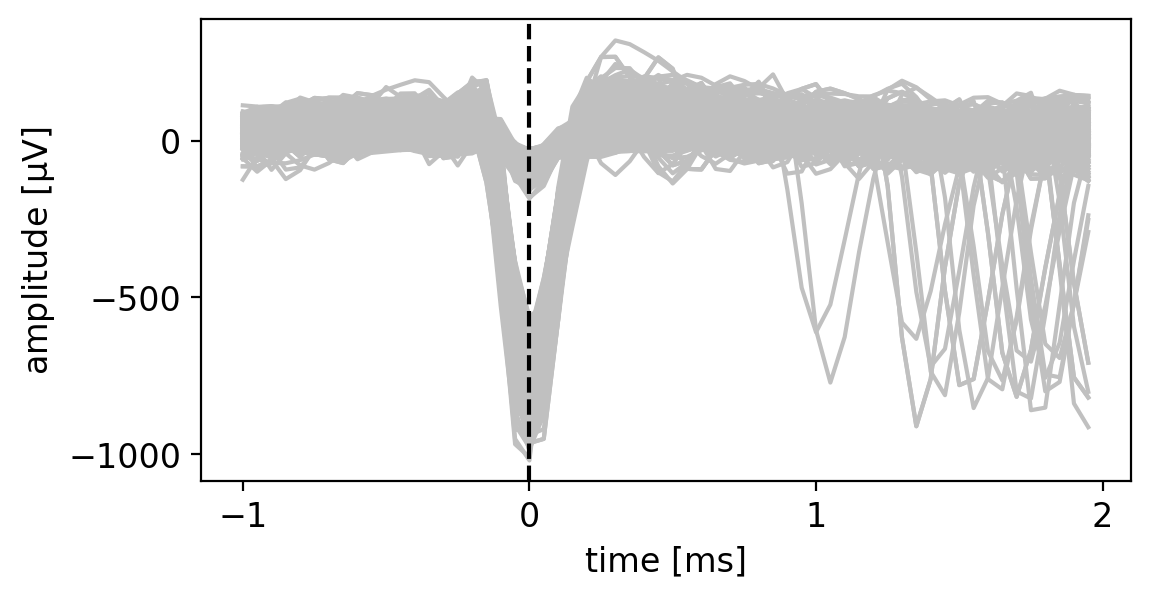

In [7]:
# randomly sample n_samples waveforms
rng = np.random.default_rng(0)
n_samples = 1000

plt.figure(figsize=(6, 3))
for waveform in rng.choice(waveforms, n_samples):
    plt.plot(t, waveform, c='#C0C0C0')
    
plt.xlabel('time [ms]')
plt.ylabel('amplitude [$\mathrm{\mu V}$]')
plt.axvline(x=0, ymin=0.0, ymax=1.0, linestyle='dashed', c='k')

plt.locator_params(axis='both', nbins=4)
plt.show()

## Feature Extraction

次のステップでは，抽出された波形（**snippets**と呼ぶ）について，何らかの特徴量を抽出し，クラスタを推定する．  
解釈性の高い特徴量としては，振幅（amplitude）やpeak-to-valley widthなどが挙げられる．一方で特徴抽出を統計的に行う場合，PCA（主成分分析）やt-SNE, UMAP等の次元圧縮手法を用いる．本ノートではPCAを例にした解析を述べる．

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

In [9]:
pca = PCA(n_components=2, random_state=0)
pca.fit(waveforms.T)
waveforms_pca = pca.components_.T

抽出された$(t_{pre} + t_{post}) \cdot f_s = 60$次元の各波形を，PCAにより2次元に圧縮した結果が次の通りである．今回の例を肉眼で観察した場合，2クラスタが最適であると考えられる．

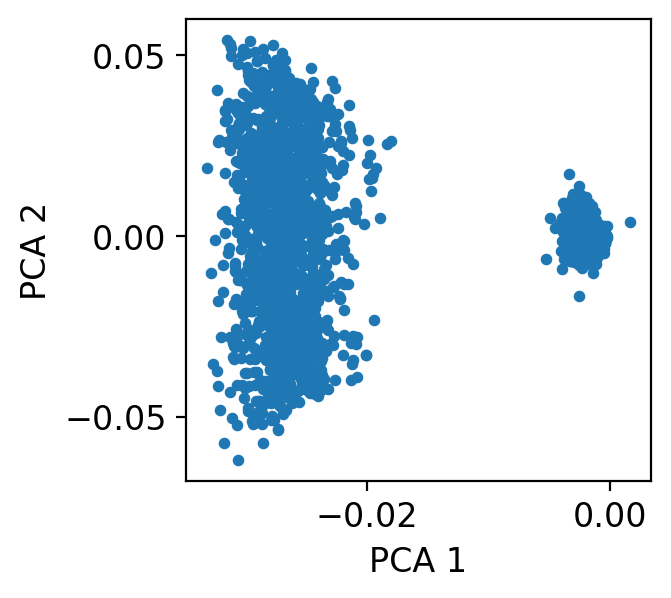

In [10]:
plt.figure(figsize=(3, 3))
plt.scatter(waveforms_pca[:, 0], waveforms_pca[:, 1], s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.locator_params(axis='both', nbins=2)
plt.show()

PCAの結果に基づき，以下で3種類のクラスタリング手法 —— k-means，GMM（Gaussian Mixture Model; 混合ガウスモデル），DBSCAN（density-based clustering; 密度ベースクラスタリング）を試行し，クラスタリング結果を比較する．

In [11]:
def plot_clusters(ax, waveforms, labels):
    for i in set(labels):
        idx = (labels == i)
        ax.scatter(x=waveforms[:, 0][idx], y=waveforms[:, 1][idx], s=10)

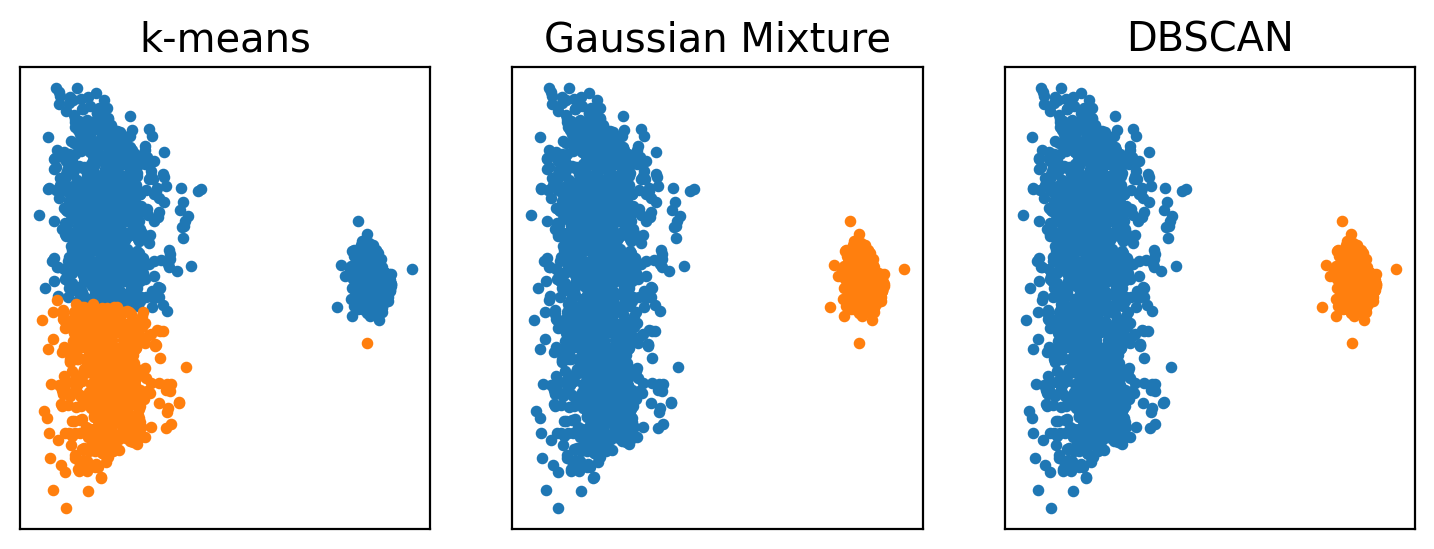

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

n_clusters = 2
km = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(waveforms_pca)
plot_clusters(ax=axes[0], waveforms=waveforms_pca, labels=km.labels_)

gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(waveforms_pca)
plot_clusters(ax=axes[1], waveforms=waveforms_pca, labels=gm.predict(waveforms_pca))

dc = DBSCAN(eps=0.01, min_samples=10).fit(waveforms_pca)
plot_clusters(ax=axes[2], waveforms=waveforms_pca, labels=dc.labels_)

titles = ['k-means', 'Gaussian Mixture', 'DBSCAN']
for ax, title in zip(axes, titles):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plt.show()

k-meansは各クラスタの分散が異なるケースに不向きであるため，左のクラスタがうまく分離できていない．一方で，GMMとDBSCANの結果は，今回のケースでは人間の直感と一致する（ただしパラメタのチューニングが適切になされているという前提がある）．

その他のクラスタリング手法を含めた各手法の比較や特徴については，scikit-learnのウェブサイトが参考になる．  
https://scikit-learn.org/stable/modules/clustering.html

spike-sortingを自動化する場合，クラスタ数などのパラメタをどのように決定するかという課題がある．k-means, GMMではクラスタ数を自動で決める必要があり，情報量基準やエルボー法といったプラクティスがある．k-meansの場合，BICを用いて拡張された手法であるx-meansを用いるという手もある．

DBSCANは，`eps`, `min_samples`の二つのパラメタを決めれば，クラスタ数が自動で決定される上，外れ値を除去できるという性質を持つ．本ノートではDBSCANを例に解析を進める．

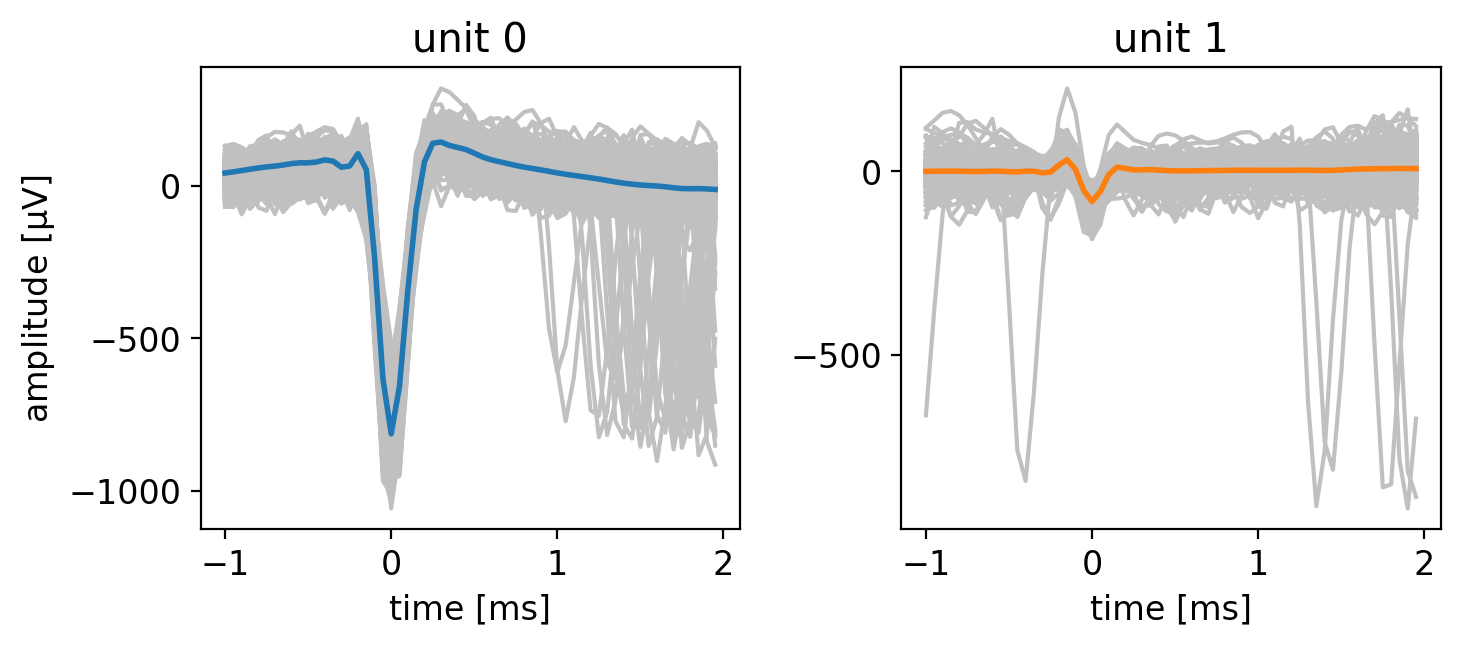

In [13]:
# clustering
dc = DBSCAN(eps=0.01, min_samples=10).fit(waveforms_pca)
labels = dc.labels_
n_clusters = np.max(labels) + 1

# plotting for each unit
fig, axes = plt.subplots(1, n_clusters, figsize=(4 * n_clusters, 3))

for i in range(n_clusters):
    ax = axes[i]
    ax.set_title(f'unit {i}')
    idx = (labels == i)
    
    # plot each waveform
    for waveform in waveforms[idx]:
        ax.plot(t, waveform, c='#C0C0C0')
        
    # plot averaged waveform
    ax.plot(t, np.mean(waveforms[idx], axis=0), linewidth=2.0, c=f'C{i}')
    
axes[0].set_xlabel('time [ms]')
axes[1].set_xlabel('time [ms]')
axes[0].set_ylabel('amplitude [$\mathrm{\mu V}$]')

plt.subplots_adjust(wspace=0.30)
plt.locator_params(axis='both', nbins=4)
plt.show()

クラスタリング結果に基づき，各クラスタに属する波形，および加算平均波形をプロットした．クラスタリング結果が正しいと仮定した場合，加算平均波形は単一細胞の波形を忠実に表しているため，**テンプレート** (template)と呼ぶ．

```{tip}
unit 0は振幅が大きく，unit 1は振幅が小さい．振幅の小さなunit 1は，SN比が相対的に低いため，特徴空間上でばらつきが大きい．unit 0の信頼性はunit 1と比較して高いが，unit 1については電極から離れたいくつかの細胞の信号が分離しきれていない可能性もある．実践的には，振幅の大きなunit 0のみを抽出し，unit 1は解析対象としない，などの判断をしても良いだろう．
```

以上では，単一の電極の信号のみを用いてspike-sortingしたが，以下では隣接する9つの全電極を用いて同様の解析を行う．

In [14]:
peaks, waveforms = extract_waveforms(sig, peaks, n_pre, n_post)
waveforms_concat = concat_waveforms(waveforms)

print(waveforms.shape)
print(waveforms_concat.shape)

(2595, 9, 60)
(2595, 540)


In [15]:
pca = PCA(n_components=2, random_state=0)
pca.fit(waveforms_concat.T)
waveforms_pca = pca.components_.T

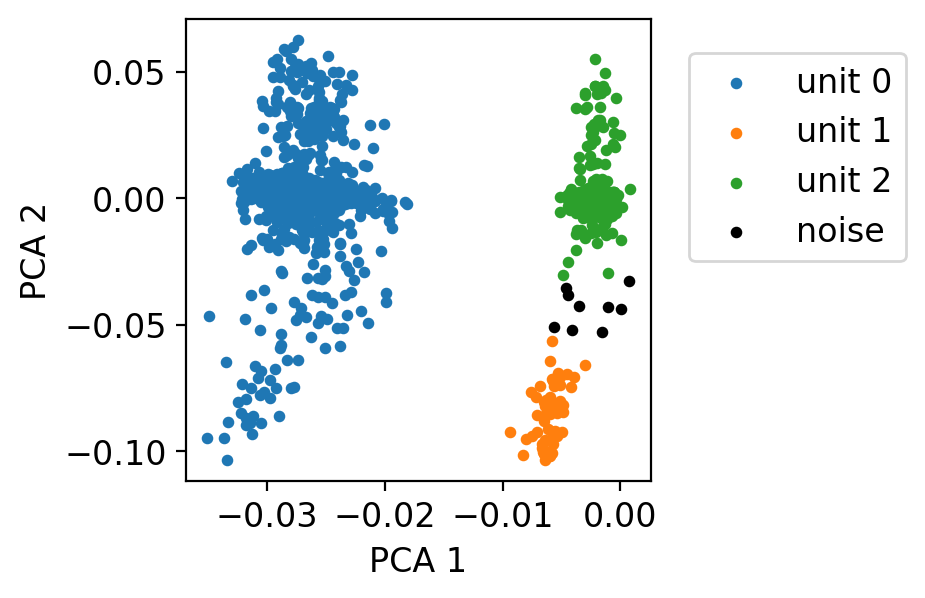

In [16]:
dc = DBSCAN(eps=0.01, min_samples=10).fit(waveforms_pca)
labels = dc.labels_
n_clusters = np.max(labels) + 1

plt.figure(figsize=(3, 3))

# units
for i in range(n_clusters):
    idx = (labels == i)
    plt.scatter(x=waveforms_pca[:, 0][idx], y=waveforms_pca[:, 1][idx], s=10, label=f'unit {i}')

# outliers are labeled as -1
idx = (labels == -1)
plt.scatter(x=waveforms_pca[:, 0][idx], y=waveforms_pca[:, 1][idx], s=10, c='k', label='noise')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1, fontsize=12)
plt.show()

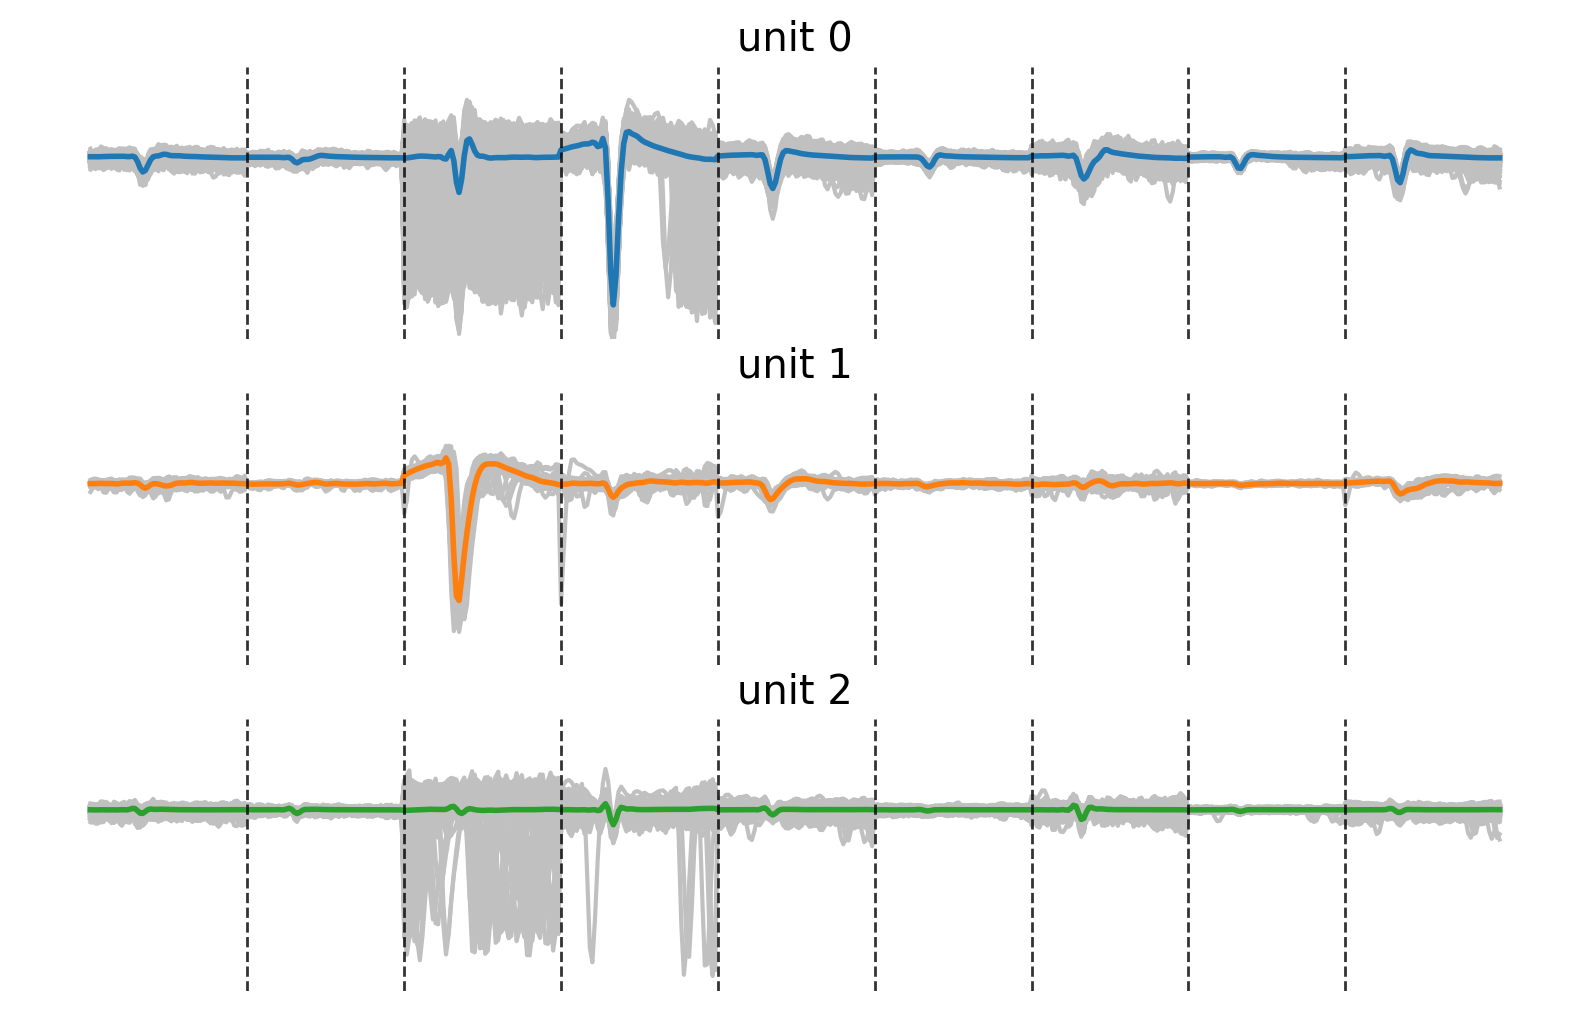

In [17]:
fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 6))

for i in range(n_clusters):
    ax = axes[i]
    ax.set_ylim(-1000, 500)
    ax.set_title(f'unit {i}')
    
    idx = (labels == i)
    for waveform in waveforms_concat[idx]:
        ax.plot(waveform, c='#C0C0C0')
        
    ax.plot(np.mean(waveforms_concat[idx], axis=0), linewidth=2.0, c=f'C{i}')
    
    ymin, ymax = ax.get_ylim()
    ax.vlines(np.arange(60, 9*60, 60), ymin=ymin, ymax=ymax, colors='k', linestyle='dashed', linewidth=1.0, alpha=0.8)
    ax.set_axis_off()

plt.show()

templateを9つの電極における信号を横に連結した形で表示した．各点線は電極の切り替わりを示す．先ほど単一の電極でspike-sortingした際に用いた電極は，左から4番目の電極である．  
先ほどのsortingでは，unit 1とunit 2が同一のクラスタとして推定されたが，左から3番目の電極において振幅が大きなneuronであるunit 1を取りこぼしていたことになる．  

このように，単一電極におけるspike波形ではなく，複数の電極にまたがったspike波形の空間的な分布の違いを活用すると，sortingの精度が向上することがわかる．

## Template Matching

上記のspike-sortingで抽出したテンプレートを用いて，spike検出をneuronごとにやり直す例を述べる．  

この方法が有効なケースは，例えば次の通りである．長期にわたる計測で全データにおけるクラスタリングが困難な場合，一部の計測のみを用いてテンプレートを作成し，残りは計算量の少ないテンプレートマッチングでneuronのspike時刻を割り当てれば，同じneuronを長期にわたって追跡することが可能である．

まず，spike-sorting同様にspike検出を行い，波形を抽出する．その後，テンプレートと抽出された各波形のコサイン類似度を取り，類似度の閾値を決め，閾値以上の類似度を持つ波形を該当ニューロンに割り当てる．

---
```{bibliography}
:filter: docname in docnames
```